# Antarctic bed and surface digital elevation model data
For this example we will load Bedmachine Antarctica version 1
https://nsidc.org/data/NSIDC-0756/versions/1

Reference: 

Morlighem, M., E. Rignot, T. Binder, D. D. Blankenship, R. Drews, G. Eagles, O. Eisen, F. Ferraccioli, R. Forsberg, P. Fretwell, V. Goel, J. S. Greenbaum, H. Gudmundsson, J. Guo, V. Helm, C. Hofstede, I. Howat, A. Humbert, W. Jokat, N. B. Karlsson, W. Lee, K. Matsuoka, R. Millan, J. Mouginot, J. Paden, F. Pattyn, J. L. Roberts, S. Rosier, A. Ruppel, H. Seroussi, E. C. Smith, D. Steinhage, B. Sun, M. R. van den Broeke, T. van Ommen, M. van Wessem, and D. A. Young. 2020. Deep glacial troughs and stabilizing ridges unveiled beneath the margins of the Antarctic ice sheet, Nature Geoscience. 13. 132-137. https://doi.org/10.1038/s41561-019-0510-8

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from intake import open_catalog

### Initalize dataset
This dataset was previously (1) downloaded from the NSIDC (link above), (2) uploaded to a publicly-assessible google bucket as a zarr, (3) pointed to by an intake catalog. The latter two steps were achieved using https://github.com/ldeo-glaciology/pangeo-bedmachine/blob/master/nc_to_zarr.ipynb and https://github.com/ldeo-glaciology/pangeo-bedmachine/blob/master/intake_catalog_setup.ipynb respectively. 

In [3]:
cat = open_catalog('https://raw.githubusercontent.com/ldeo-glaciology/pangeo-bedmachine/master/bedmachine.yaml')
ds  = cat["bedmachine"].to_dask()
ds

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    bed        (y, x) float32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    errbed     (y, x) float32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    firn       (y, x) float32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    geoid      (y, x) int16 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    mask       (y, x) int8 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    source     (y, x) int8 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    surface    (y, x) float32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    thickness  (y, x) float32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
Attributes:
    Author:                                 Mathieu Morlighem
    Conventions:                            CF-1.7
    Data_citation:                          Morlighem M. et al., (2019), Deep...
    Notes:                                  Data processed at the Department ...
    Projection:                             Polar Stereographic South (71S,0E)
    Title:                                  BedMachine Antarctica
    false_easting:                          [0.0]
    false_northing:                         [0.0]
    grid_mapping_name:                      polar_stereographic
    ice_density (kg m-3):                   [917.0]
    inverse_flattening:                     [298.2794050428205]
    latitude_of_projection_origin:          [-90.0]
    license:                                No restrictions on access or use
    no_data:                                [-9999.0]
    nx:                                     [13333.0]
    ny:                                     [13333.0]
    proj4:                                  +init=epsg:3031
    sea_water_density (kg m-3):             [1027.0]
    semi_major_axis:                        [6378273.0]
    spacing:                                [500]
    standard_parallel:                      [-71.0]
    straight_vertical_longitude_from_pole:  [0.0]
    version:                                05-Nov-2019 (v1.38)
    xmin:                                   [-3333000]
    ymax:                                   [3333000]

### check how big the dataset is
(its not very large - only 4.2 GB - but still slower to download and process in a conventioanl way that in pangeo)

In [4]:
ds.nbytes/1e9

4.26656

### plot some of the data to take a look at one of the fields
Subset and plot the ice thickness

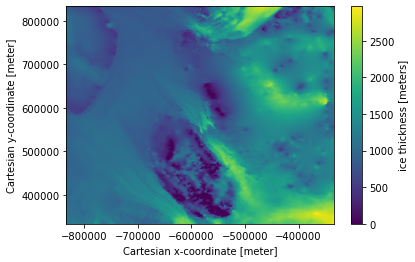

In [5]:
ds.thickness.isel(x=slice(5000,6000), y = slice(5000,6000)).plot()

### start a cluster to do some fast processing of this relatively small dataset

In [6]:
from dask.distributed import Client
import dask_gateway

gateway = dask_gateway.Gateway()
cluster = gateway.new_cluster()


In [7]:
cluster.scale(4)
client = Client(cluster)
cluster

#### to view the dask scheduler dashboard either click the link above, or copy the link in to the serach bar in the dask tab on the right, prefixing it with https://us-central1-b.gcp.pangeo.io/ - then you get access to all the tool and they can be docked in this window. 

### do a simple calculation that requires three of the dataarrays in their entirety
compute the mean thickness from the difference between surface and bed heights and compare that to the mean of the thickness datarray

In [8]:
diff = ds.surface - ds.bed   # take the difference between the surface and the bed
ice_surf_bed_diff = diff.where(ds.mask!=0)   # only consider places where there is ice (i.e. where mask is not equal to zero)
mean_surf_bed_diff = ice_surf_bed_diff.mean()  # compute the mean 

this hasnt done any computation, it has just prepared the computation. 

surf_bed_diff is just a place holder for a 13333x13333 array 

In [10]:
mean_surf_bed_diff

<xarray.DataArray ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

and mt1 is just a place holder for a sinlge value (the mean of hte difference)

In [11]:
mean_surf_bed_diff

<xarray.DataArray ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

### execute the computation
.load() is one of several dask commands that causes the computation to be executed.

In [12]:
%%time
mean_surf_bed_diff.load()

CPU times: user 22.4 ms, sys: 4.66 ms, total: 27 ms
Wall time: 9.28 s


<xarray.DataArray ()>
array(1944.0841, dtype=float32)

note that if you call mt1.load() again it generally will not waste time computing the result again as it has it stored in the cluster memory (unless somehting has cleared in the meantime since the block above was called, e.g., `del mean_surf_bed_diff` ). It just returns the result again.

In [13]:
%%time
mean_surf_bed_diff.load()

CPU times: user 225 µs, sys: 0 ns, total: 225 µs
Wall time: 234 µs


<xarray.DataArray ()>
array(1944.0841, dtype=float32)

### now compare this to the mean of the thickness field

In [14]:
%%time
mt2 = ds.thickness.where(ds.mask!=0).mean().load()
mt2

CPU times: user 24.3 ms, sys: 2.24 ms, total: 26.5 ms
Wall time: 1.49 s


<xarray.DataArray 'thickness' ()>
array(1916.2861, dtype=float32)

#### its close but not exactly the same, which is to be expected. 

### Make some plots, making use of coarsen. 
Plot the two thickness field and the differnece between them, making use of course, so that we dont need to download the whole dataset just for these plots. 

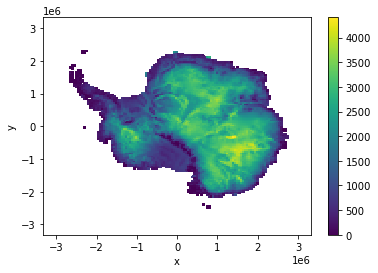

In [15]:
ice_surf_bed_diff.coarsen(x=100,y=100,boundary="trim").mean().plot()

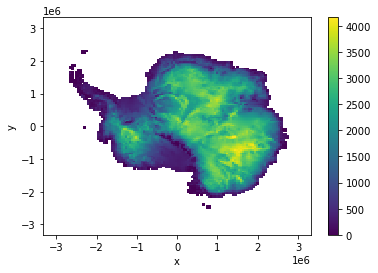

In [16]:
ds.thickness.where(ds.mask!=0).coarsen(x=100,y=100,boundary="trim").mean().plot()

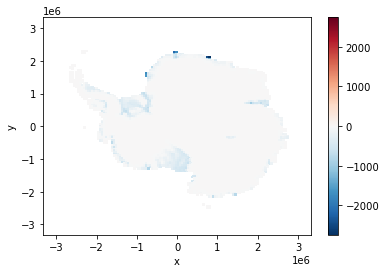

In [17]:
mismatch = ds.thickness - ice_surf_bed_diff
mismatch.where(ds.mask!=0).coarsen(x=100,y=100,boundary="trim").mean().plot()